In [120]:
import numpy as np
import imageio
import astra
import sys
import matplotlib.pyplot as plt

In [121]:
proj_dim = 256
# name = "shepp_logan"
# name = "au_ag_sirt"
name = "tube"

range_ = 180
step = 1

In [122]:
def get_tube_volume(volume_size=256):
    tube_diameter = volume_size//5
    margin = volume_size//5

    center_x = volume_size // 2
    center_y = volume_size // 2

    x = np.linspace(0, volume_size - 1, volume_size)
    y = np.linspace(0, volume_size - 1, volume_size)
    z = np.linspace(0, volume_size - 1, volume_size)

    X, Y, Z = np.meshgrid(x, y, z, indexing='xy')

    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    inside_tube_radius = distance_from_center <= (tube_diameter / 2)

    inside_tube_length = (Z >= margin) & (Z <= volume_size-margin)

    return inside_tube_radius & inside_tube_length

In [123]:
def get_padded_volume(volume, pad_size):

    return np.pad(volume, 
                  tuple((pad_size, pad_size) for _ in range(3)), 
                  mode='constant', 
                  constant_values=0)

In [124]:
out_folder = "data/benchmark"
try:
    vol_path = f"{out_folder}/{name}.npy"
    volume = np.load(vol_path)

except:
    if name == "shepp_logan":
        from phantominator import shepp_logan
        
        pad_size = 62
        vol_dim = proj_dim-pad_size
        volume = shepp_logan((vol_dim, vol_dim, vol_dim))

        if vol_dim != proj_dim:
            padded_volume = get_padded_volume(volume, pad_size)
            
        np.save(f"{out_folder}/{name}_{proj_dim}.npy", padded_volume)
    
    elif name == "tube":
        volume = get_tube_volume(proj_dim)
        np.save(f"{out_folder}/{name}_{proj_dim}.npy", volume)
    else:
        sys.exit()

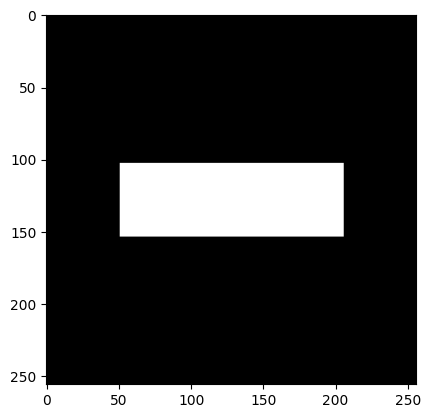

In [128]:
plt.imshow(volume[:, proj_dim//2, :], cmap="grey")

In [126]:
vol_dim  = volume.shape[0]

rest = -range_/2 
angles = np.arange(rest, (range_+rest if rest < 0 else range_-rest)+step, step) 
num_projections = len(angles)

proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, proj_dim, proj_dim, np.radians(angles))
vol_geom  = astra.create_vol_geom(volume.shape[0], volume.shape[1], volume.shape[2])

projector_id = astra.create_projector('cuda3d', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino3d_gpu(volume, proj_geom, vol_geom)

astra.data3d.delete(sinogram_id)
astra.projector.delete(projector_id)

sinogram = np.swapaxes(sinogram, 0, 1) # [H, N, W] -> [N, H, W]
imageio.mimwrite(f'{out_folder}/{name}_{range_}.tiff', sinogram)

sinogram_8bit = (255 * (sinogram - np.min(sinogram)) / (np.max(sinogram) - np.min(sinogram))).astype(np.uint8)
imageio.mimwrite(f'{out_folder}/{name}_{range_}_8bit.tiff', sinogram_8bit)

with open(f'{out_folder}/{name}_{range_}.txt', 'w') as angle_file:
    for angle in angles:
        angle_file.write(f"{angle}\n")

In [127]:
# # Define the parameters
# vol_dim = 256  # Example volume dimensions
# angles = np.arange(0, 5, 0.5)  # Angle range from 0 to 5 degrees with 0.5 degree steps
# num_projections = len(angles)
# det_row_count = vol_dim  
# det_col_count = vol_dim 

# det_spacing_x = 1.0
# det_spacing_y = 1.0

# source_origin_dist = 1000  # Distance from source to origin
# origin_detector_dist = 500  # Distance from origin to detector

# # Corrected call to create_proj_geom
# proj_geom = astra.create_proj_geom('cone', det_spacing_x, det_spacing_y, det_row_count, det_col_count, np.radians(angles), 
#                                    source_origin_dist, origin_detector_dist)

# # Create volume geometry
# vol_geom = astra.create_vol_geom(vol_dim, vol_dim, vol_dim)

# # Create the projector
# projector_id = astra.create_projector('cuda3d', proj_geom, vol_geom)

# # Example volume data
# volume = np.ones((vol_dim, vol_dim, vol_dim), dtype=np.float32)

# # Create the sinogram
# sinogram_id, sinogram = astra.create_sino3d_gpu(volume, proj_geom, vol_geom)